In [2]:
from concise.hyopt import CMongoTrials, get_data
import numpy as np
import pandas as pd
import data
from helper import *
from tqdm import tqdm_notebook as tqdm

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

def print_exp(exp_name):
    print("-" * 40 + "\nexp_name: " + exp_name)


DIR_ROOT = "/s/project/deepcis/encode/eclip/"
DIR_ROOT = "/home/avsec/projects-work/deepcis/data/encode/eclip/"
RBP_LIST = ["UPF1", "PUM2", "DDX3X", "NKRF", "TARDBP", "SUGP2"]

DB_NAME = "RBP__Eclip"
HOST = "ouga03"
#HOST = "localhost"

#EXPERIMENTS = ["DeepNN",
#               "DeepNN_scalar_position_gam",
#               "DeepNN_scalar_position_relu",
#               "DeepNN_track_position_gam",
#               "DeepNN_track_position_relu"]
EXPERIMENTS = ["DeepNN_2",
               "DeepNN_scalar_position_gam_2",
               "DeepNN_scalar_position_relu_2"]
data_fn = data.data

In [3]:
def get_best_model(rbp, exp_name):
    trials = CMongoTrials(DB_NAME, exp_name + "_" + rbp, ip=HOST)
    tid = trials.best_trial_tid()
    param = trials.get_param(tid)
    return trials.load_model(tid), param

In [40]:
# cache get_data
from concise.hyopt import get_data
from tempfile import mkdtemp
from joblib import Memory

memory = Memory(cachedir=mkdtemp(), verbose=0)

get_data = memory.cache(get_data)

## Develop

In [7]:
rbp_name = "UPF1"

In [9]:
m_relu, param_relu = get_best_model(rbp_name, EXPERIMENTS[2])

In [10]:
m_relu.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq (InputLayer)                 (None, 101, 4)        0                                            
____________________________________________________________________________________________________
conv_dna_1 (ConvDNA)             (None, 91, 16)        720                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 91, 16)        364                                          
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 91, 16)        272                                          
___________________________________________________________________________________________

In [11]:
from keras.models import Model
from concise.preprocessing import encodeSplines

In [13]:
tss_in = m_relu.get_layer("raw_dist_tss_log").input
polya_in = m_relu.get_layer("raw_dist_polya_log").input
tss_out = m_relu.get_layer("conv1d_2").output
polya_out = m_relu.get_layer("conv1d_4").output
relu_tss_m = Model(tss_in, tss_out)
relu_polya_m = Model(polya_in, polya_out)

In [14]:
# Generate a range of values
x_ls = np.linspace(0, 1, 100)
xs_ls = encodeSplines(x_ls, m_gam.get_layer("dist_tss_log").input.shape[2].value, start = 0, end = 1)

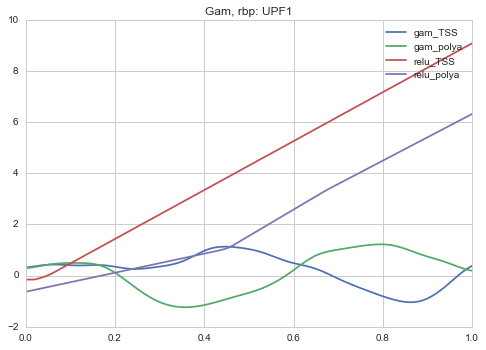

In [15]:
plt.plot(x_ls, gam_tss_m.predict(xs_ls).reshape((-1)), label="gam_TSS")
plt.plot(x_ls, gam_polya_m.predict(xs_ls).reshape((-1)), label="gam_polya")
plt.plot(x_ls, relu_tss_m.predict(x_ls.reshape((-1,1, 1))).reshape((-1)), label="relu_TSS")
plt.plot(x_ls, relu_polya_m.predict(x_ls.reshape((-1,1, 1))).reshape((-1)), label="relu_polya")
plt.legend()
plt.title("Gam, rbp: {0}".format(rbp_name))

## Run for all

In [41]:
@memory.cache
def get_positions(rbp_name):  
    m_gam, param_gam = get_best_model(rbp_name, EXPERIMENTS[1])
    m_relu, param_relu = get_best_model(rbp_name, EXPERIMENTS[2])
    
    #gam
    tss_in = m_gam.get_layer("dist_tss_log").input
    polya_in = m_gam.get_layer("dist_polya_log").input
    tss_out = m_gam.get_layer("conv_splines_1").output
    polya_out = m_gam.get_layer("conv_splines_2").output
    gam_tss_m = Model(tss_in, tss_out)
    gam_polya_m = Model(polya_in, polya_out)

    # relu
    tss_in = m_relu.get_layer("raw_dist_tss_log").input
    polya_in = m_relu.get_layer("raw_dist_polya_log").input
    tss_out = m_relu.get_layer("conv1d_2").output
    polya_out = m_relu.get_layer("conv1d_4").output
    relu_tss_m = Model(tss_in, tss_out)
    relu_polya_m = Model(polya_in, polya_out)
    
    # TODO - weight the model by the downstream weight
    
    
    # input value range
    
    # Generate a range of values
    x_ls = np.linspace(0, 1, 100)
    xs_ls = encodeSplines(x_ls, m_gam.get_layer("dist_tss_log").input.shape[2].value, start = 0, end = 1)
    return x_ls, \
    gam_tss_m.predict(xs_ls).reshape((-1)), \
    gam_polya_m.predict(xs_ls).reshape((-1)),\
    relu_tss_m.predict(x_ls.reshape((-1,1, 1))).reshape((-1)), \
    relu_polya_m.predict(x_ls.reshape((-1,1, 1))).reshape((-1))

def plot_positions(x_ls, p_tss_gam, p_polya_gam, p_tss_relu, p_polya_relu, ax=None):
    ax = ax or plt.gca()
    ax.plot(x_ls, p_tss_gam, label="gam_TSS")
    ax.plot(x_ls, p_polya_gam, label="gam_polya")
    ax.plot(x_ls, p_tss_relu, label="relu_TSS")
    ax.plot(x_ls, p_polya_relu, label="relu_polya")
    ax.set_title("{0}".format(rbp_name))

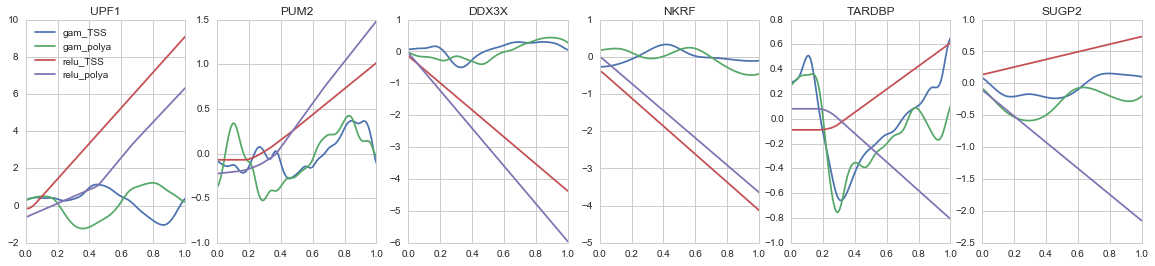

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=len(RBP_LIST), figsize=(20, 4))

for i, rbp_name in enumerate(tqdm(RBP_LIST)):
    x_ls, p_tss_gam, p_polya_gam, p_tss_relu, p_polya_relu = get_positions(rbp_name)
    plot_positions(x_ls, p_tss_gam, p_polya_gam, p_tss_relu, p_polya_relu, ax=ax[i])
ax[0].legend(loc=0);

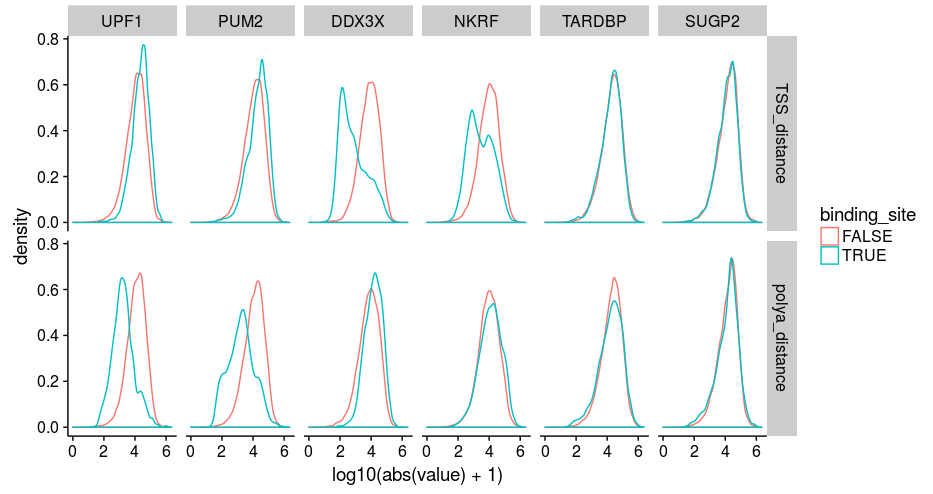

In [84]:
from IPython.display import Image
Image(filename='/data/ouga/home/ag_gagneur/avsec/projects-work/deepcis/data/plots/RBP/Eclip/position_screenshot.png')

## Conclusions

- seems that the positions shouldn't be interepreted directly